<img src='https://radiant-assets.s3-us-west-2.amazonaws.com/PrimaryRadiantMLHubLogo.png' alt='Radiant MLHub Logo' width='300'/>

# 2019 Mali Crop Type Model Training Tutorial
# A Guide to Training a Baseline Model


This notebook walks you through the steps to build a model using U-Net for the 2019 Mali crop type dataset.

## Dependencies

This notebook utilizes [`Tensorflow`](https://www.tensorflow.org) for building and training the model.

The notebook uses the `Pillow` [package](https://pillow.readthedocs.io/en/stable/reference/Image.html) for loading the RGB `.tif` images, [`numpy`](https://numpy.org/doc/stable/) for numerical calculations, particularly for arrays and [`matplotlib`](https://matplotlib.org/stable/gallery/index) was used for visualising our results.

In [14]:
#required libraries
import random
import seaborn as sns
import json
import matplotlib.pyplot as plt
import os
from pathlib import Path
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam 

In [3]:
#source and label file paths
data = Path("./data").resolve()
source = Path("./data/umd_mali_crop_type_source").resolve()
label = Path("./data/umd_mali_crop_type_labels").resolve()

We will then map the source images with their respective labels, for our training, testing and validation data.

For example, `umd_mali_crop_type_source_31` label file represents the label for source images with the following expression: `umd_mali_crop_type_source_31_XXXX_XX_XX` where `XXXX_XX_XX` represents the timestamp the source image was obtained from in `YYYY-MM-DD` format.

In [4]:
#locate source and label items
src_files=next(os.walk(source))[1]
label_loc=next(os.walk(label))[1]
#exclude _common folder, as it's not a label folder
label_loc.remove('_common')
#find the label ID e.g num is 31 in umd_mali_crop_type_source_31
X= np.zeros((len(src_files), 256, 256,3), dtype=np.uint8)
Y= np.zeros((len(src_files), 256, 256), dtype=np.uint8)
j=0
for item in label_loc:
    num=item.split('_')[5]
    field = np.asarray(Image.open(f"{label}/{item}/labels.tif")) #load label image
    for src in src_files:
        if src[:-11]==f"umd_mali_crop_type_source_{num}": #find all source items belonging to that label ID
            source_img=np.asarray(Image.open(f"{data}/rgb_source/{src}.tif"))
            X[j]=source_img
            Y[j]=field
            j=j+1

We will then examine some properties of the dataset, such as the class distribution.

First, we will check what the ID of each raster represents. To do this, we load a `raster_mapping.json` file from a random label item (we chose `17` here). We can see the contents of the item below.

'0' represents no data, '1' represents millet crop, '2' represents maize, '3' for sorghum and '4' for rice.

In [26]:
data = json.load(open(f"{label}/umd_mali_crop_type_labels_17/raster_mapping.json"))

In [34]:
data

{'0': 'No Data', '1': 'millet', '2': 'maize', '3': 'sorghum', '4': 'rice'}

We will map the items (crop ids) and their properties (crop names) into a list.

Then we will use `numpy` to calculate how many pixels each crop item occupies in the entire dataset and evaluate that as a percentage of the total pixels in the dataset.

In [40]:
id=[]
property=[]
for item in data: #raster mapping data
    id.append(int(item)) #add crop id to id list
    property.append(data[item]) #add property to property list
values, counts = np.unique(Y, return_counts=True) #find how many pixels are in the label dataset

In [16]:
total_count=0 #initialise total count for all pixels
percentage=[] #use for percentage for each item
for i in counts:
    total_count+=i #total pixels
for i in counts:
    percentage.append((i/total_count)*100) #percentage for each pixel

In [43]:
#displaying the items and their respective distributions.
print("we have the following unqiue values:", value)
print("the values have the following counts (in %age):", percentage)

we have the following unqique values: ['No Data', 'millet', 'maize', 'sorghum', 'rice']
the values have the following counts (in %age): [99.76043701171875, 0.07273356119791666, 0.04794958866003788, 0.09696266867897728, 0.02191716974431818]


We can see that almost certainly, the entire dataset is filled with `No Data`.

Next, we will split the data into the training, test and validation data. We chose a `70:15:15` `train:validation:test` split ratio.

In [5]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)

In [5]:
#check the shapes of each data set
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(947, 256, 256, 3)
(947, 256, 256)
(203, 256, 256, 3)
(203, 256, 256)
(203, 256, 256, 3)
(203, 256, 256)


Text(0.5, 1.0, 'actual label')

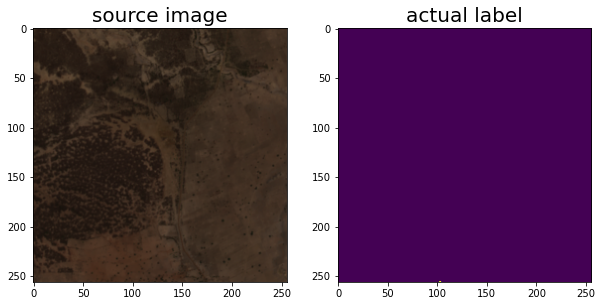

In [6]:
#randomly viewing the images
i=random.randint(0, len(x_train)-1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
#fig.suptitle('Horizontally stacked subplots')
ax1.imshow(x_train[i])
ax1.set_title("source image", fontsize=20)
ax2.imshow(y_train[i])
ax2.set_title("actual label", fontsize=20)

Next, we will build the model which would be used to solve the crop type problem.

Youcef Guichi provided an effective model based on U-Net to tackle a similar issue, which can be found [here](https://www.kaggle.com/yesa911/aerial-semantic-segmentation-96-acc)

In [7]:
def conv_block(inputs=None, n_filters=4, dropout_prob=0, max_pooling=True):
    #code reference: https://www.kaggle.com/yesa911/aerial-semantic-segmentation-96-acc
    conv = Conv2D(n_filters, #filter number to determine number of abstractions the network is able to extract from image data
                  kernel_size = 3,   #3x3  
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(inputs)
    conv = Conv2D(n_filters, 
                  kernel_size = 3, 
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(conv)

    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
        
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

def upsampling_block(expansive_input, contractive_input, n_filters=32):
    
    up = Conv2DTranspose(
                 n_filters,  
                 kernel_size = 3,
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,  
                 kernel_size = 3,   
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(merge)
    
    conv = Conv2D(n_filters,  
                 kernel_size = 3,  
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(conv)
    
    
    return conv

In [8]:
def unet_model(input_size=(256, 256, 3), n_filters=4, n_classes=5): #number of classes
    #code reference: https://www.kaggle.com/yesa911/aerial-semantic-segmentation-96-acc
    inputs = Input(input_size)
    
    #contracting path
    cblock1 = conv_block(inputs, n_filters)
    
    cblock2 = conv_block(cblock1[0], 2*n_filters)
    
    cblock3 = conv_block(cblock2[0], 4*n_filters)
    
    cblock4 = conv_block(cblock3[0], 8*n_filters, dropout_prob=0.3) 
    
    cblock5 = conv_block(cblock4[0],16*n_filters, dropout_prob=0.3, max_pooling=None)  
    
    #expanding path
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  8 * n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters*4)
    ublock8 = upsampling_block(ublock7,cblock2[1] , n_filters*2)
    ublock9 = upsampling_block(ublock8,cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)
    #conv9 = BatchNormalization()(conv9)
    conv10 = Conv2D(n_classes, kernel_size=1, padding='same')(conv9)  
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [9]:
img_height = 256 #our image size
img_width = 256
num_channels = 3 #modify since we have 3 channels (rgb)

unet = unet_model((img_height, img_width, num_channels))

In [10]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 4)  112         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 4)  148         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 4)  0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [11]:
#save the model based on best validation loss
model_checkpoint = ModelCheckpoint(str(data)+'/unet_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
#stop training if no improvements after 50 epochs
model_earlyStopping = EarlyStopping(min_delta= 0.001, patience=50) #stop after 50 epochs if no improvements

In [12]:
#setting up and compiling the model
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.003, name="Adam"
)
loss= loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
unet.compile(optimizer=optimizer, loss= loss,\
                  metrics = ['accuracy'])

Finally, we will fit and train the model, using the parameters which have been described earlier

In [13]:
batch_size=8
history = unet.fit(x=x_train, y=y_train,
              validation_data=(x_val, y_val),
              steps_per_epoch = len(x_train)//batch_size,
              validation_steps = len(x_val)//batch_size,
              batch_size=batch_size, epochs=100, callbacks=[model_checkpoint, model_earlyStopping])

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-05-15 21:52:26.611602: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-15 21:52:26.613783: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz


118/118 [==============================] - ETA: 0s - loss: 0.6937 - accuracy: 0.9879WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x1459c6310> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
118/118 [==============================] - 19s 153ms/step - loss: 0.6901 - accuracy: 0.9880 - val_loss: 0.0348 - val_accuracy: 0.9976

E

118/118 [==============================] - 17s 145ms/step - loss: 0.0196 - accuracy: 0.9976 - val_loss: 0.0202 - val_accuracy: 0.9976

Epoch 00032: val_loss did not improve from 0.01755
Epoch 33/100
118/118 [==============================] - 17s 145ms/step - loss: 0.0202 - accuracy: 0.9976 - val_loss: 0.0197 - val_accuracy: 0.9976

Epoch 00033: val_loss did not improve from 0.01755
Epoch 34/100
118/118 [==============================] - 17s 145ms/step - loss: 0.0201 - accuracy: 0.9976 - val_loss: 0.0204 - val_accuracy: 0.9976

Epoch 00034: val_loss did not improve from 0.01755
Epoch 35/100
118/118 [==============================] - 17s 144ms/step - loss: 0.0212 - accuracy: 0.9974 - val_loss: 0.0196 - val_accuracy: 0.9976

Epoch 00035: val_loss did not improve from 0.01755
Epoch 36/100
118/118 [==============================] - 17s 145ms/step - loss: 0.0189 - accuracy: 0.9977 - val_loss: 0.0196 - val_accuracy: 0.9976

Epoch 00036: val_loss did not improve from 0.01755
Epoch 37/100
118/1

Next, we will load the trained model and make some predictions with it

In [5]:
import os
os.chdir(str(data)+"/unet_model.hdf5")

NotADirectoryError: [Errno 20] Not a directory: '/Users/mac/Downloads/umd_mali_crop_type/data/unet_model.hdf5'

In [8]:
loaded_model = tf.keras.models.load_model(str(data)+'/unet_model.h5') #loading the model

We will then evaluate the model on the test data set. 
To do this, we will use the `model.evaluate` function on each of the items and then find the average loss and accuracy on the entire set.

In [ ]:
losses=0
accuracies=0
for i in range(len(x_test)):
    losses+= loaded_model.evaluate(np.expand_dims(x_test[i], 0),np.expand_dims(y_test[i], 0), verbose=0)[0]
    accuracies+=loaded_model.evaluate(np.expand_dims(x_test[i], 0),np.expand_dims(y_test[i], 0), verbose=0)[1]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [49]:
avg_loss=losses/len(x_test)
avg_accuracy=accuracies/len(x_test)
print("The average loss on the test set is: ", avg_loss)
print("The average accuracy on the test set is: ", avg_accuracy*100, "%")

The average loss on the test set is:  0.017510891346068216
The average accuracy on the test set is:  99.78788028209668 %


We can finally view the results of the model's performance on the test data as seen below

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 227ms/step - loss: 0.0157 - accuracy: 0.9979
[0.015661900863051414, 0.9978790283203125]
187


Text(0.5, 1.0, 'predicted label')

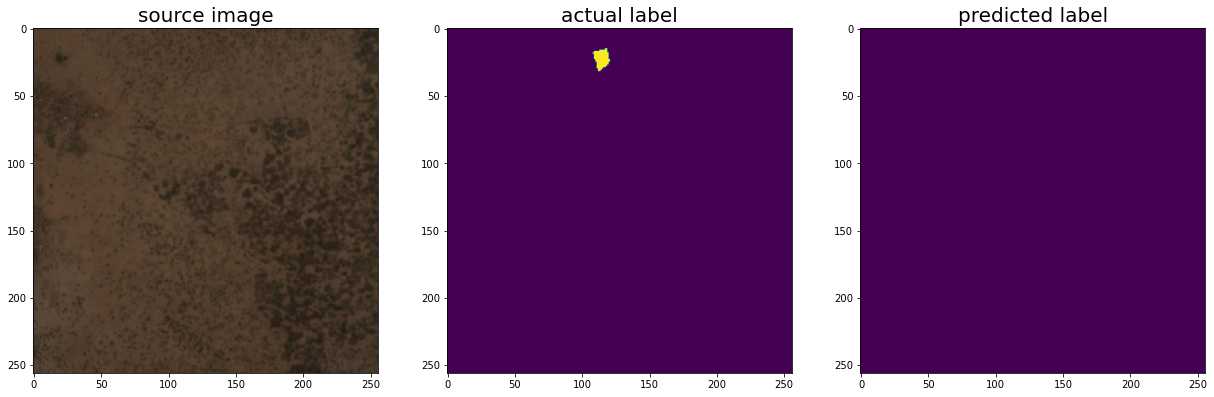

In [67]:
import random
i=random.randint(0, len(x_test)-1)
test_result= loaded_model.evaluate(np.expand_dims(x_test[i], 0),np.expand_dims(y_test[i], 0))
pred_mask = loaded_model.predict(np.expand_dims(x_test[i], 0))
pred_mask = np.argmax(pred_mask, axis=-1)
pred_mask = pred_mask[0]
print(test_result) #print results on the random field
print (i) #print ID
# Perform a sanity check on some random test samples
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21,10.80))
#fig.suptitle('Horizontally stacked subplots')
ax1.imshow(x_test[i])
ax1.set_title("source image", fontsize=20)
ax2.imshow(y_test[i])
ax2.set_title("actual label", fontsize=20)
ax3.imshow(pred_mask)
ax3.set_title("predicted label", fontsize=20)

Next, we will display a confusion matrix of the results. To do this, first we load the UNet model from the directory, which makes predictions on the test data

In [10]:
y_pred = loaded_model.predict(x_test)
y_pred = np.argmax(pred_mask, axis=-1)

We define the following parameters:

- FP = False Positive = an outcome where the model incorrectly predicts the positive class.

- FN = False Negative = an outcome where the model incorrectly predicts the negative class.

- TP = True Positive = an outcome where the model correctly predicts the positive class.

- TN = True Negative = an outcome where the model correctly predicts the negative class.

Positive class refers to the class being evaluated.

Negative class in this case refers to other classes except the class being evaluated.

In [17]:
FP = len(np.where(y_pred - y_test == -1)[0]) #false positive
FN = len(np.where(y_pred - y_test  == 1)[0]) #false negative
TP = len(np.where(y_pred + y_test ==2)[0]) #true positive
TN = len(np.where(y_pred + y_test == 0)[0]) #true negative
cmat = [[TP, FN], [FP, TN]] #confusion matrix setup

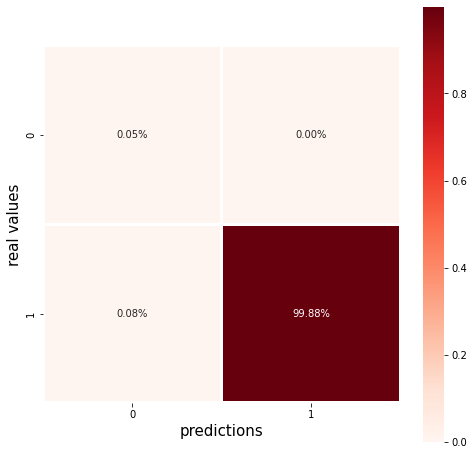

In [35]:
#plotting confusion matrix
plt.figure(figsize = (8,8))
sns.heatmap(cmat/np.sum(cmat), cmap="Reds", annot=True, fmt = '.2%', square=1,   linewidth=2.)
plt.xlabel("predictions", fontsize=15)
plt.ylabel("real values", fontsize=15)
plt.show()